### Raster Interface 

This notebook will give an overview of the newly added functionality for Raster Interface

In [1]:
%matplotlib inline

from libpysal.weights import Rook, Queen, KNN
from libpysal.weights import raster
import numpy as np
import xarray as xr
import pandas as pd
from esda import Moran_Local

Right now only `xarray.DataArray` is supported, therefore we'll use `open_rasterio`method to access the raster. Since the this method is built on top of `rasterio` hence file type compatibilty of this method is similar to that of `rasterio`. 

In [2]:
# Loading raster data with missing values
da1 = xr.open_rasterio('nasadem_sd.tif')
# Slicing the dataarray
da1 = da1[:, 0:100, 350:400]
da1.shape

(1, 100, 50)

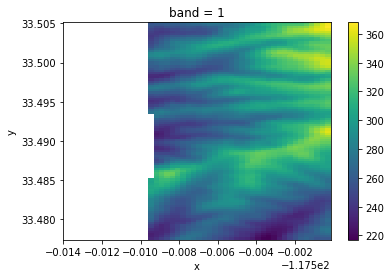

In [3]:
# ploting dataarray after removing missing values
da1.where(da1.data>da1.attrs["nodatavals"]).plot()

We can use `from_xarray` method from the contiguity classes like `Rook` and `Queen`, and also from `KNN`.

This uses a util function in raster file called `da2W`, which can also be called directly to build `W` object, similarly `da2WSP` for building `WSP` object

In [4]:
# Let's check the method first
help(Rook.from_xarray)

Help on method from_xarray in module libpysal.weights.contiguity:

from_xarray(da, band=None, sparse=False, **kwargs) method of builtins.type instance
    Construct a weights object from a xarray DataArray.
    
    Parameters
    ----------
    da : xarray.DataArray
        raster file accessed using xarray.open_rasterio method
    band : int
        select band for raster with multiple bands
    sparse : boolean
        type of weight object. Default is dense. For sparse, sparse = True
    **kwargs : keyword arguments
        optional arguments passed when sparse = False 
    
    Returns
    -------
    w : libpysal.weights.W/libpysal.weights.WSP
    instance of spatial weights class W or WSP
    
    See Also
    --------
    :class:`libpysal.weights.weights.W`
    :class:`libpysal.weights.weights.WSP`



In [5]:
# Creating weight of object from raster
w_rook = Rook.from_xarray(da1)

Lets check the index attributes added to the `W` object 

In [6]:
# coords contains the multi-indices of non-missing data values 
w_rook.index[:5]

MultiIndex([(1, 33.505, -117.50944444444444),
            (1, 33.505, -117.50916666666666),
            (1, 33.505, -117.50888888888889),
            (1, 33.505, -117.50861111111111),
            (1, 33.505, -117.50833333333333)],
           names=['band', 'y', 'x'])

Here we first convert the `DataArray` to `Series` and then use the indices from `index` attribute to remove missing values by subsetting the `Series` 

In [7]:
# Loading the raster data for further calculation
data1 = da1.to_series()[w_rook.index]
data1[:5]

band  y       x          
1     33.505  -117.509444    256
              -117.509167    261
              -117.508889    263
              -117.508611    263
              -117.508333    264
dtype: int16

In [8]:
# Quickly computing and loading a LISA
np.random.seed(12345)
lisa = Moran_Local(data1,w_rook)

`to_xarray` is an instance method of `W` object which converts the `W` object back to `DataArray`, we can also use `w2da` function directly to do the same.

In [9]:
# Let's check the method first
help(w_rook.to_xarray)

Help on method to_xarray in module libpysal.weights.weights:

to_xarray(data, attrs={}, coords=None) method of libpysal.weights.weights.W instance
    Creates DataArray object from passed data
    
    Parameters
    ---------
    data : array/list
        numpy 1d array or list with dimensionality conforming to w
    attrs : Dictionary
        Attributes stored in dict related to DataArray e.g. da.attrs
    coords : Dictionary/xarray.core.coordinates.DataArrayCoordinates
        coordinates corresponding to DataArray e.g. da.coords
    
    Returns
    -------
    da : xarray.DataArray
        instance of xarray.DataArray



In [10]:
# Converting obtained data back to DataArray
moran_da1 = w_rook.to_xarray(lisa.p_sim)
print(moran_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[-1.   , -1.   , -1.   , ...,  0.072,  0.066,  0.133],
        [-1.   , -1.   , -1.   , ...,  0.054,  0.063,  0.108],
        [-1.   , -1.   , -1.   , ...,  0.084,  0.115,  0.187],
        ...,
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001],
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001],
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 33.48 33.48 33.48 33.48 33.48 ... 33.5 33.5 33.5 33.51
  * x        (x) float64 -117.5 -117.5 -117.5 -117.5 ... -117.5 -117.5 -117.5
Attributes:
    nodatavals:  (-1,)


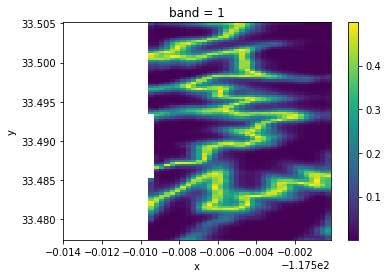

In [11]:
# Plotting the converted DataArray
moran_da1.where(moran_da1.data>0).plot()

Will perform similar operations with different data, we'll see another way we can use build to perform same operations

In [12]:
# Lets load a different raster data with multiple bands 
da2 = xr.open_rasterio('HARV_RGB_Ortho.tif')
# Slicing the dataarray
da2 = da2[:, 0:100, 350:400]
da2.shape

(3, 100, 50)

This time we'll directly create weights without calling the builders from contiguity class, but we need to specify which contiguity to build

In [13]:
wsp_queen = raster.da2WSP(da2, "queen")

/data/GSoC/libpysal/libpysal/weights/raster.py:149: UserWarning: Multiple bands detected in da. Using band 1 as default band
  warn('Multiple bands detected in da. Using band 1 as default band')


 Now instead of using `lisa` will store back a `pandas.Series` containing random values to the `DataArray`.

In [14]:
ser = pd.Series(np.random.randint(0,9, len(wsp_queen.index)))

In [15]:
# Converting obtained data back to DataArray
ser_da1 = raster.w2da(ser, wsp_queen)
print(ser_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[4, 8, 4, ..., 1, 4, 4],
        [4, 4, 1, ..., 4, 4, 3],
        [0, 0, 0, ..., 7, 1, 4],
        ...,
        [1, 5, 1, ..., 1, 2, 8],
        [0, 3, 0, ..., 0, 5, 4],
        [4, 5, 2, ..., 5, 7, 1]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.714e+06 4.714e+06 4.714e+06 ... 4.714e+06 4.714e+06
  * x        (x) float64 7.321e+05 7.321e+05 7.321e+05 ... 7.321e+05 7.321e+05


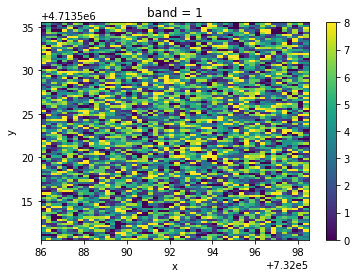

In [16]:
# Plotting the converted DataArray
ser_da1.plot()

To save some time we can use the metadata of the original `DataArray` to build the new `DataArray` much faster

In [17]:
# Converting obtained data back to DataArray
ser_da1 = raster.w2da(ser, wsp_queen, da1.attrs, da1.coords)
print(ser_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[4, 8, 4, ..., 1, 4, 4],
        [4, 4, 1, ..., 4, 4, 3],
        [0, 0, 0, ..., 7, 1, 4],
        ...,
        [1, 5, 1, ..., 1, 2, 8],
        [0, 3, 0, ..., 0, 5, 4],
        [4, 5, 2, ..., 5, 7, 1]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 33.51 33.5 33.5 33.5 33.5 ... 33.48 33.48 33.48 33.48
  * x        (x) float64 -117.5 -117.5 -117.5 -117.5 ... -117.5 -117.5 -117.5
Attributes:
    transform:      (0.0002777777777777778, 0.0, -117.61125, 0.0, -0.00027777...
    crs:            +init=epsg:4326
    res:            (0.0002777777777777778, 0.0002777777777777778)
    is_tiled:       0
    nodatavals:     (-32768.0,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area
